# Object in scene classificaion

In [25]:
# built-ins
import json
from pathlib import Path

# third party import
import cv2
import numpy as np
from PIL import Image
import fiftyone.brain as fob
import matplotlib.pyplot as plt

# custom imports
from src.data.dataset import * 

# Load dataset (COCO format)

We merge train and val as train set in this task

In [26]:
datasets = []
for split in ['train', 'valid']:
    dataset_root = Path(f'data/{split}')
    annotation_fp = dataset_root / '_annotations.coco.json'
    dataset = get_dataset(dataset_root, annotation_fp)
    datasets.append(dataset)
train_dataset = merge_datasets(datasets)

dataset_root = Path(f'data/{"test"}')
annotation_fp = dataset_root / '_annotations.coco.json'
test_dataset = get_dataset(dataset_root, annotation_fp)


   0% ||----------------|   1/360 [31.4ms elapsed, 11.3s remaining, 31.9 samples/s] 

 100% |█████████████████| 360/360 [602.8ms elapsed, 0s remaining, 602.4 samples/s]      
 100% |█████████████████| 101/101 [175.4ms elapsed, 0s remaining, 597.5 samples/s] 
 100% |███████████████████| 51/51 [86.9ms elapsed, 0s remaining, 587.1 samples/s]  


### Parse scene labels from json files

In [27]:
import json
def parse_user_tags(json_fp: Path) -> dict:
    # Read the JSON file
    with open(json_fp, 'r') as f:
        data = json.load(f)

    # Initialize a dictionary to store image IDs and corresponding user_tags
    image_user_tags_dict = {}

    # Iterate over the images
    for image in data['images']:
        image_id = image['file_name'].split('.')[2]
        user_tags = image.get('extra', {}).get('user_tags', [])
        image_user_tags_dict[image_id] = user_tags

    return image_user_tags_dict

train_tags = parse_user_tags(Path('data/train/_annotations.coco.json'))
valid_tags = parse_user_tags(Path('data/valid/_annotations.coco.json'))
test_tags = parse_user_tags(Path('data/test/_annotations.coco.json'))

# combine the tags
combined_tags = {**train_tags, **valid_tags, **test_tags}

### Extract image paths and labels

In [42]:
import cv2
import numpy as np
from numpy import asarray

error_count = 0
train_imgs = []
train_true_labels = []

for idx, sample in enumerate(train_dataset):
    print(f"Processing idx:{idx}",end="\r")
    image = cv2.imread(sample['filepath'],0)
    img_normalized = cv2.normalize(image, None, 0, 1.0,
        cv2.NORM_MINMAX, dtype=cv2.CV_32F)  
    img_normalized_resize = cv2.resize(img_normalized, (225, 225))
    train_imgs.append(asarray(img_normalized_resize))
    if sample['detections'] is None:
        train_true_labels.append(0)
    else:
        train_true_labels.append(1)

train_imgs = np.array(train_imgs)
train_true_labels = np.array(train_true_labels)

print(f"Failed to add tags to {error_count} samples")

Failed to add tags to 0 samples


In [43]:
error_count = 0
test_imgs = []
test_true_labels = []

for idx, sample in enumerate(test_dataset):
    print(f"Processing idx:{idx}",end="\r")
    image = cv2.imread(sample['filepath'],0)
    img_normalized = cv2.normalize(image, None, 0, 1.0,
        cv2.NORM_MINMAX, dtype=cv2.CV_32F)  
    img_normalized_resize = cv2.resize(img_normalized, (225, 225))
    test_imgs.append(asarray(img_normalized_resize))
    if sample['detections'] is None:
        test_true_labels.append(0)
    else:
        test_true_labels.append(1)

test_imgs = np.array(test_imgs)
test_true_labels = np.array(test_true_labels)


print(f"Failed to add tags to {error_count} samples")

Failed to add tags to 0 samples


In [44]:
train_imgs = train_imgs.reshape(train_imgs.shape[0], -1)
test_imgs = test_imgs.reshape(test_imgs.shape[0], -1)
print(train_imgs.shape)
print(train_true_labels.shape)
print(test_imgs.shape)
print(test_true_labels.shape)

(461, 50625)
(461,)
(51, 50625)
(51,)


Train MSE: 0.0000
Test MSE: 0.3238
Train Accuracy: 100.0000%
Test Accuracy: 80.3922%


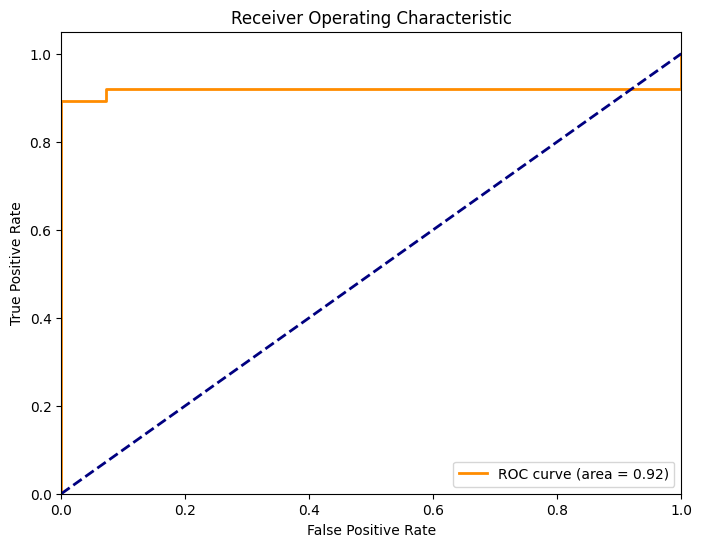

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(train_imgs, train_true_labels)

# Predict on the training data
train_preds = model.predict(train_imgs)

# Predict on the test data
test_preds = model.predict(test_imgs)

# Threshold predictions to get binary outcomes
train_preds_binary = np.round(train_preds)
test_preds_binary = np.round(test_preds)

# Evaluate the model
train_mse = mean_squared_error(train_true_labels, train_preds)
test_mse = mean_squared_error(test_true_labels, test_preds)
train_accuracy = accuracy_score(train_true_labels, train_preds_binary)
test_accuracy = accuracy_score(test_true_labels, test_preds_binary)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train Accuracy: {train_accuracy:.4%}")
print(f"Test Accuracy: {test_accuracy:.4%}")

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_true_labels, test_preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

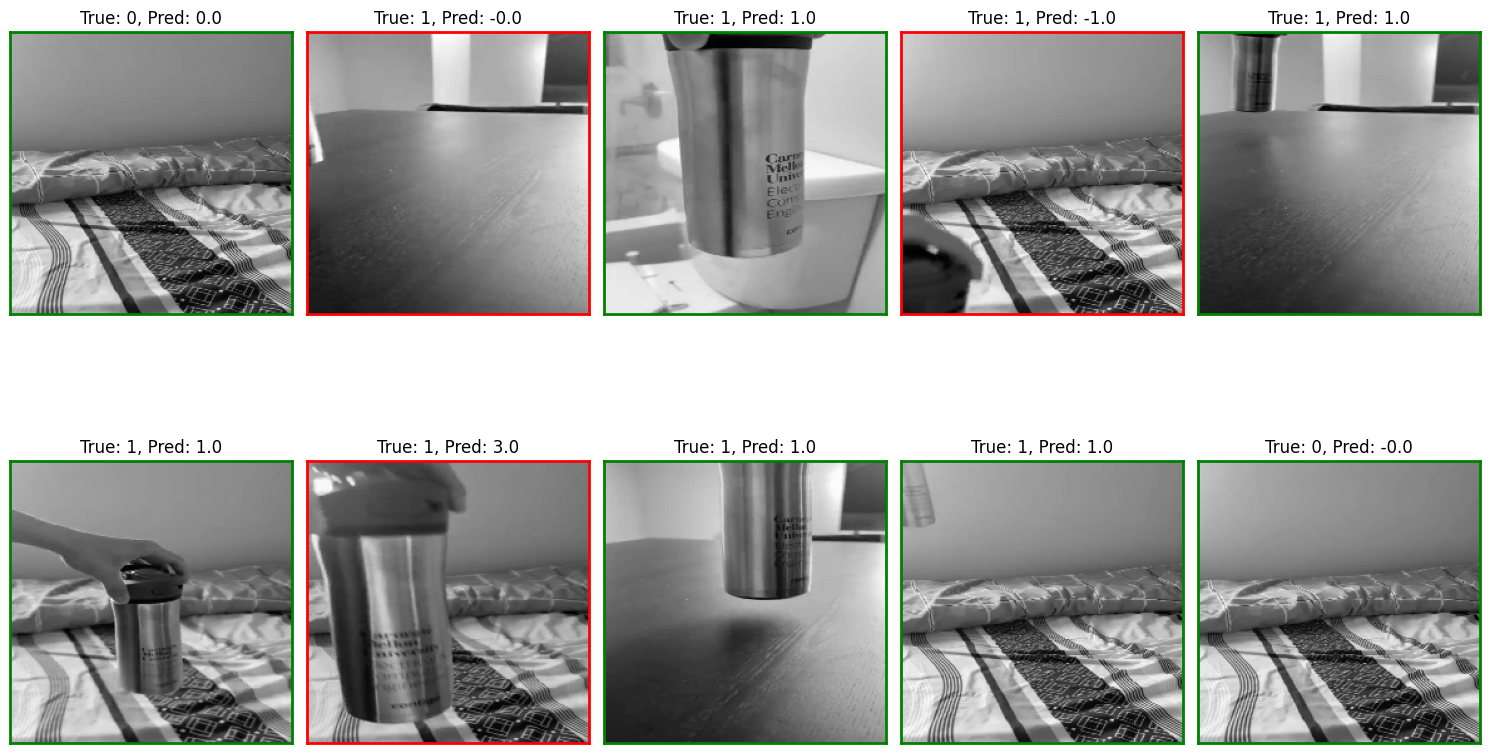

In [47]:
import matplotlib.pyplot as plt

def plot_images(images, true_labels, predicted_labels, num_images=10):
    # Set up the figure size and number of images
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(np.arange(len(images)), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, num_images//2, i + 1)  # Adjust layout for number of images
        plt.imshow(images[idx].reshape((image_height, image_width)), cmap='gray')  # Adjust reshape based on image dimensions
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
        plt.xticks([]), plt.yticks([])  # Remove ticks
        plt.grid(False)
        # Highlight the border in red if prediction is incorrect
        for spine in plt.gca().spines.values():
            spine.set_edgecolor('red' if true_labels[idx] != predicted_labels[idx] else 'green')
            spine.set_linewidth(2)

    plt.tight_layout()
    plt.show()

image_height, image_width = 225, 225  # Change this based on your image dimensions
plot_images(test_imgs, test_true_labels, test_preds_binary)